In this notebook we will be doing an A/B testing for the bounce rated of two home page from data set provided by Maven Analytics in their Udemy course "Advanced SQL + MySQL for Analytics & Business Intelligence", which contains data from an ecommerce store called "Maven Fuzzy Factory". 

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt

## Getting the Data

First we will use "mysql.connector" to access the data base and get the data we need.

In '2012-06-19' Maven Fuzzy Factory decided to add a new home page to their website looking to improve the bouncing rates (the percentage of times that a person leaves the website) from their current home page called **"/home"**. We will collect the data of a little over 6 months (until another home page was added) and test if the new home page called **"/lander-1"** delivered better results.

In [2]:
temp_table = """
CREATE TEMPORARY TABLE entry_pageview
SELECT 
    ws.website_session_id,
    MIN(wp.website_pageview_id) AS entry_pageview_id
FROM
    website_sessions ws
        INNER JOIN
    website_pageviews wp ON ws.website_session_id = wp.website_session_id
	AND ws.created_at between '2012-06-19' AND '2013-01-12'
GROUP BY 1;
"""

query = """
SELECT 
    MIN(created_at) AS view_date,
    w.pageview_url,
    CASE
        WHEN COUNT(w.website_pageview_id) = 1 THEN 1
        ELSE 0
    END AS is_bounce
FROM
    entry_pageview e
        LEFT JOIN
    website_pageviews w ON e.website_session_id = w.website_session_id
GROUP BY entry_pageview_id;
"""

connection = mysql.connector.connect(user='root', password='password',
                                    host='localhost',
                                    database='mavenfuzzyfactory')
cursor = connection.cursor()

cursor.execute(temp_table)
cursor.execute(query)

num_cols = len(cursor.description)
col_names = [i[0] for i in cursor.description]
df = cursor.fetchall()

cursor.close()
connection.close()

Let's take a look at our data. A value of is_bounce=1 represents a bounced session (user session was terminated after visiting the homepage), and a value of is_bounce=0 non-bounced session.

Sessions that started at another page different than **"/home"** and **"/lander-1"** were not taken into account.

In [3]:
df = pd.DataFrame(df, columns=col_names)
df.head()

,view_date,pageview_url,is_bounce
0,2012-06-19 00:35:54,/lander-1,1
1,2012-06-19 00:48:25,/home,1
2,2012-06-19 01:02:38,/lander-1,1
3,2012-06-19 01:31:57,/lander-1,0
4,2012-06-19 01:36:39,/home,1


# 1st Month
Let's get the performance over the first month

In [4]:
df_month1 = df.query("view_date <= '2012-07-19'")

home = df_month1.query("pageview_url == '/home'").is_bounce.values
p1 = np.mean(home)
n1 = len(home)

lander_1 = df_month1.query("pageview_url == '/lander-1'").is_bounce.values
p2 = np.mean(lander_1)
n2 = len(lander_1)

print(f'home:\nBounce Rate: {p1:.4f}, Page Visits: {n1}',)
print(f'lander-1:\nBounce Rate: {p2:.4f}, Page Visits: {n2}',)

home:
Bounce Rate: 0.5433, Page Visits: 2240
lander-1:
Bounce Rate: 0.5462, Page Visits: 1796


We can see that their performance is very similiar. We'll run our hypothesis test to make sure that there is not a significant difference, but before we have to check if our samples are big enough in order for to use the normal distribution.

We'll check that
$$\left[\hat{p}-3 \sqrt{\frac{\hat{p}(1-\hat{p}}{n}}, \hat{p}+3 \sqrt{\frac{\hat{p}(1-\hat{p}}{n}} \right] \subset [0,1]$$

for each page.

In [5]:
def var(p,n):
    s = (p*(1-p))/n
    return s 

In [6]:
h_low, h_up = p1-3*np.sqrt(var(p1,n1)),p1+3*np.sqrt(var(p1,n1))
l_low, l_up = p2-3*np.sqrt(var(p2,n2)),p2+3*np.sqrt(var(p2,n2))

print(f'home: ({h_low:.4f},{h_up:.4f})')
print(f'lander: ({l_low:.4f},{l_up:.4f})')
print('\nBoth intervals are inside the interval [0,1]')

home: (0.5117,0.5749)
lander: (0.5110,0.5815)

Both intervals are inside the interval [0,1]


## Hypothesis Testing
We want to test if the bounce rate for "lander-1" is different from the bounce rate of "/home" at a .05 level of significance. We'll let p1 be the bouncing rate of "/home" and p2 be bouncing rate of "lander-1".

Then our hypothesis will be formulated as follows:

$$H_0: p_1 - p_2 = 0$$
$$H_a: p_1 - p_2 > 0 $$
$$\alpha=.05$$

Let's proceed to our test:

In [7]:
from scipy.stats import norm

In [8]:
alpha = .05
z = ((p1-p2) - 0) / np.sqrt(var(p1,n1)+var(p2,n2))
p_value = 1 - norm.cdf(z)

print(f'Z: {z:.4f}')
print(f'p_value: {p_value}\nalpha: {alpha:.4f}')
print(f'{p_value:.4f} > {alpha}')
print('Failed to Reject Null Hypothesis')

Z: -0.1845
p_value: 0.5731935645926902
alpha: 0.0500
0.5732 > 0.05
Failed to Reject Null Hypothesis


For the first month at a 5% level of significance we can conclude that "\lander-1" is not performing better than "\home"

Let's analyze the data for the full experiment (about 6 months until an additional home page was introduced), and plot the weekly bounce rates of each home page.

We'll need a new querie for that.

# Six Months

In [9]:
# Get entry page_view per session 
temp_table1 = """
CREATE TEMPORARY TABLE entry_pageview
SELECT 
    ws.website_session_id,
    MIN(wp.website_pageview_id) AS entry_pageview_id
FROM
    website_sessions ws
        INNER JOIN
    website_pageviews wp ON ws.website_session_id = wp.website_session_id
        AND ws.created_at BETWEEN '2012-06-19' AND '2013-01-12'
GROUP BY 1;
"""

# Get table of weekly sessions and bounce sessions per page
temp_table2 = """
CREATE TEMPORARY TABLE weekly_sessions_bounced
SELECT 
    pageview_url,
    WEEK(created_at) AS week_,
    min(date(created_at)) AS week_date, 
    COUNT(website_session_id) AS sessions,
    SUM(is_bounce) AS bounced_sessions
FROM
    (SELECT 
        e.website_session_Id,
            w.created_at,
            w.pageview_url,
            CASE
                WHEN COUNT(w.website_pageview_id) = 1 THEN 1
                ELSE 0
            END AS is_bounce
    FROM
        entry_pageview e
    LEFT JOIN website_pageviews w ON e.website_session_id = w.website_session_id
    GROUP BY entry_pageview_id) AS session_isbounce
GROUP BY 1 , 2;

"""

# Set variables for cumulative sum
variables = """
SET 
    @cum_sessions_home := 0,
    @cum_sessions_lander := 0,
    @cum_bounced_home := 0,
    @cum_bounced_lander := 0;
"""

# add cumulative sum for sessions and bounce sessions, and cumulative bounce rate
query = """
SELECT 
    q.*, cum_bounced / cum_sessions AS cum_bounce_rate
FROM
    (SELECT 
        w.*,
            CASE
                WHEN w.pageview_url = '/home' THEN (@cum_sessions_home:=@cum_sessions_home + w.sessions)
                ELSE (@cum_sessions_lander:=@cum_sessions_lander + w.sessions)
            END AS cum_sessions,
            CASE
                WHEN w.pageview_url = '/home' THEN (@cum_bounced_home:=@cum_bounced_home + w.bounced_sessions)
                ELSE (@cum_bounced_lander:=@cum_bounced_lander + w.bounced_sessions)
            END AS cum_bounced
    FROM
        weekly_sessions_bounced w
    ORDER BY w.pageview_url , cum_sessions ASC) AS q;

"""

connection = mysql.connector.connect(user='root', password='password',
                                    host='localhost',
                                    database='mavenfuzzyfactory')
cursor = connection.cursor()

cursor.execute(temp_table1)
cursor.execute(temp_table2)
cursor.execute(variables)
cursor.execute(query)

num_cols = len(cursor.description)
col_names = [i[0] for i in cursor.description]
df_cum = cursor.fetchall()

cursor.close()
connection.close()

In [10]:
df_cum = pd.DataFrame(df_cum, columns=col_names)
df_home_cum = df_cum.query("pageview_url == '/home'")
df_lander1_cum = df_cum.query("pageview_url == '/lander-1'")

In [11]:
df_cum

,pageview_url,week_,week_date,sessions,bounced_sessions,cum_sessions,cum_bounced,cum_bounce_rate
0,/home,25,2012-06-19,397,204,397,204,0.5139
1,/home,26,2012-06-24,497,268,894,472,0.5280
2,/home,27,2012-07-01,504,280,1398,752,0.5379
3,/home,28,2012-07-08,514,285,1912,1037,0.5424
4,/home,29,2012-07-15,566,306,2478,1343,0.5420
...,...,...,...,...,...,...,...,...
57,/lander-1,51,2012-12-16,2212,1178,39447,20999,0.5323
58,/lander-1,52,2012-12-23,1233,660,40680,21659,0.5324
59,/lander-1,53,2012-12-30,192,97,40872,21756,0.5323
60,/lander-1,0,2013-01-01,736,378,41608,22134,0.5320


## Data Visualization

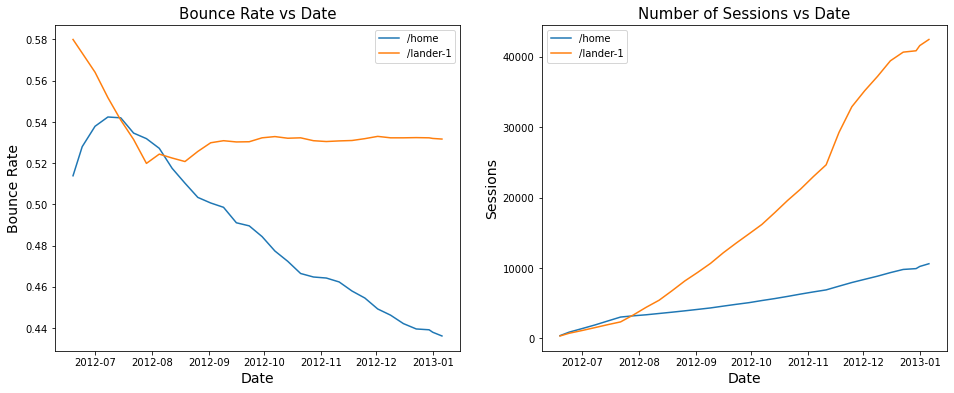

In [12]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(df_home_cum.week_date,df_home_cum.cum_bounce_rate, label='/home')
ax[0].plot(df_lander1_cum.week_date,df_lander1_cum.cum_bounce_rate, label='/lander-1')
ax[0].set_xlabel('Date', size=14)
ax[0].set_ylabel('Bounce Rate', size=14)
ax[0].set_title('Bounce Rate vs Date', size=15)
ax[0].legend();

ax[1].plot(df_home_cum.week_date,df_home_cum.cum_sessions, label='/home')
ax[1].plot(df_lander1_cum.week_date,df_lander1_cum.cum_sessions, label='/lander-1')
ax[1].set_xlabel('Date', size=14)
ax[1].set_ylabel('Sessions', size=14)
ax[1].set_title('Number of Sessions vs Date', size=15)
ax[1].legend();

We can see that although "/lander-1" seemed to be performing better at the beginnig, in the long run the bounce rate "/home"  decreace steadily and ended up lower. We can also observe that "/lander-1" had way more sessions that "/home", about 30,000 more.

Let's perform our hypothesis testing. We'll use the same formulated hypothesis.

## Hypothesis Testing

In [13]:
home = df.query("pageview_url == '/home'").is_bounce.values
p1 = np.mean(home)
n1 = len(home)

lander_1 = df.query("pageview_url == '/lander-1'").is_bounce.values
p2 = np.mean(lander_1)
n2 = len(lander_1)

print(f'home:\nBounce Rate: {p1:.4f}, Page Visits: {n1}',)
print(f'lander-1:\nBounce Rate: {p2:.4f}, Page Visits: {n2}',)

home:
Bounce Rate: 0.4362, Page Visits: 10616
lander-1:
Bounce Rate: 0.5317, Page Visits: 42479


Again we need to check if our sample is big enough.

In [14]:
h_low, h_up = p1-3*np.sqrt(var(p1,n1)),p1+3*np.sqrt(var(p1,n1))
l_low, l_up = p2-3*np.sqrt(var(p2,n2)),p2+3*np.sqrt(var(p2,n2))

print(f'home: ({h_low:.4f},{h_up:.4f})')
print(f'lander: ({l_low:.4f},{l_up:.4f})')
print('\nBoth intervals are inside the interval [0,1]')

home: (0.4218,0.4507)
lander: (0.5244,0.5389)

Both intervals are inside the interval [0,1]


We'll procede to compute the test.

In [15]:
alpha = .05
z = ((p1-p2) - 0) / np.sqrt(var(p1,n1)+var(p2,n2))
p_value = 1 - norm.cdf(z)

print(f'Z-value: {z:.4f}')
print(f'p-value: {p_value:.4f}\nalpha: {alpha}')
print(f'{p_value:.4f} > {alpha}')
print('Failed to Reject Null Hypothesis')

Z-value: -17.7110
p-value: 1.0000
alpha: 0.05
1.0000 > 0.05
Failed to Reject Null Hypothesis


As expected, we failed to reject the null hypothesis again. The p-value=1 shows that, as we saw in our plot, there is overwhelmingly evidence that the bounce rate of "/lander" is not less than the bounce rate of "/home"

Let'se see what the overall bounce rate was.

In [16]:
b_rate = np.sum(df.is_bounce)/len(df.is_bounce)
n = len(df)

print(f'Overall Bounce Rate: {b_rate:.4f}')
print(f'Total Sessions: {n}')

Overall Bounce Rate: 0.5126
Total Sessions: 53095


We got a overall bounce rate of 51.26% for our landing pages, which is not very good. Note that "/lander-1" was excesively used and turned out not to be the optimal landing page. This could've been avoided using an optimization algorithm.  

## Bayesian Bandits

We'll run an experiment using Bayesian Bandits to show the optimal landing page most of the times.

We will use the Bayes Theorem to estimate the bounce rate for each landing page.

$$ p(\theta|X)\: \alpha\: p(X|\theta)p(\theta)$$

Since we are dealing with a Bernoulli likelihood $p(X|\theta)$, we'll use a Beta distribution (its conjugate prior) to calculate the posterior $p(\theta|X)$

$$ p(\theta|X) = Beta(\alpha\, +\, \Sigma_{i=1}^Nx_i,\, \beta\, +\, N\, -\, \Sigma_{i=1}^Nx_i )$$

We'll use our calculated bounce rates as our true rates to simulate the outcome for each page view. Then, from each lander, we'll take a sample coming from a Beta distribution and "show" the sampler with the smaller one (Thompson Sampling). As the experiment progresses the parameters from the beta distribution will be updated according to the outcome and each lander will approach their true rates. 

In [17]:
from scipy.stats import beta

In [18]:
class Lander:
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1
        self.N = 0 
        
    def pull(self):
        return np.random.random() < self.p
    
    def sample(self):
        return np.random.beta(self.a, self.b)
    
    # for online updating we are computing the posterior in terms of a single sample.
    def update(self, x):
        self.a += x
        self.b = self.b + 1 - x
        self.N += 1

In [19]:
def plot(landers, trial):
    
    x = np.linspace(0,1,200)
    home, lander = landers[0], landers[1]
    br_home = (home.a - 1)/home.N
    br_lander = (lander.a - 1)/lander.N
    y_home = beta.pdf(x, home.a, home.b)
    y_lander = beta.pdf(x, lander.a, lander.b)
    
    fig = plt.subplots(figsize=(7,5))
    plt.plot(x, y_home, label=f'/home: bounce rate = {br_home:.4f}, sessions = {home.N}') 
    plt.plot(x, y_lander, label=f'/lander-1: bounce rate = {br_lander:.4f}, sessions = {lander.N}') 
    plt.title(f"Landers distributions after {trial} sessions")
    plt.legend(loc='best')
    plt.show()   

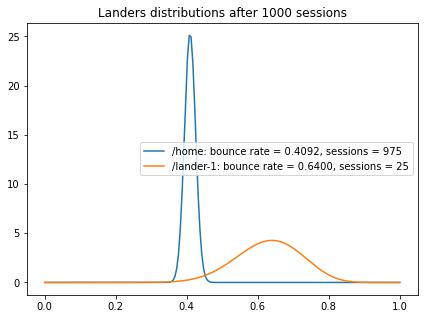

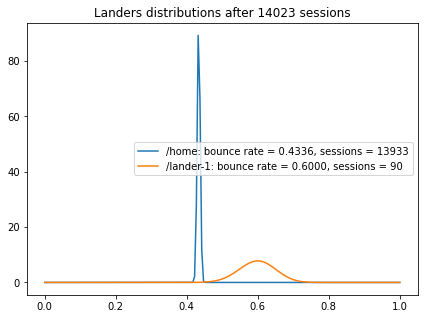

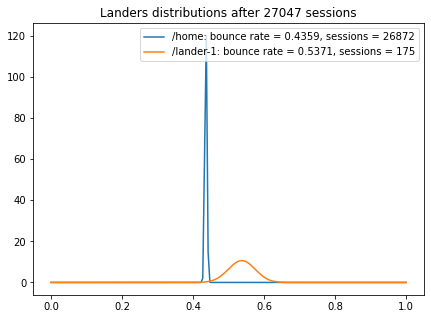

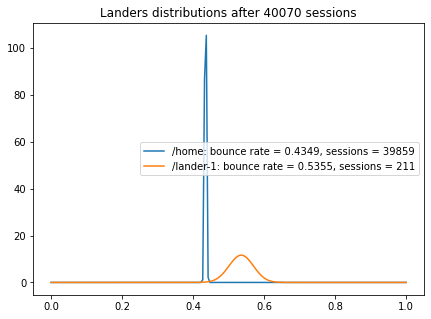

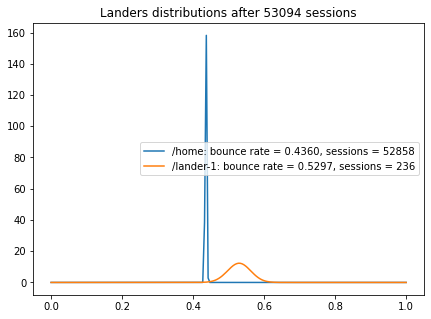

Overall Bounce Rate: 0.4364


In [20]:
plot_points = [int(i) for i in np.linspace(1000,len(df)-1,5)]

home = Lander(p1)
lander_1 = Lander(p2)
landers = [home,lander_1]
is_bounce = []

for i in range(len(df)):
    # Thompson sampling
    j = np.argmin([lander.sample() for lander in landers])
    
    # plot the posteriors
    if i in plot_points:
        plot(landers, i)
    
    # pull the arm from the bandit with the smaller sample
    x = landers[j].pull()
    
    # update outcome
    is_bounce.append(x)
    
    # update the distribution for the bandit whose arm was pulled
    landers[j].update(x)
    
print(f'Overall Bounce Rate: {np.sum(is_bounce)/len(is_bounce):.4f}')

We can see how each lander approaches its true rate. and "/home" gets selected way more because the sample drawn from its Beta distribution has a higher probablitity to be the lower one. This also lowered the overall bounce rate to 43.64%